In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from astropy.table import Table
from tqdm import tqdm
import scipy
import jax

rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('400_BCE_Data_processed.csv', time_oversample=50)
cf.prepare_function(use_control_points=True, interp="gp")

In [3]:
cf.annual

DeviceArray([-426, -425, -424, -423, -422, -421, -420, -419, -418, -417,
             -416, -415, -414, -413, -412, -411, -410, -409, -408, -407,
             -406, -405, -404, -403, -402, -401, -400, -399, -398, -397,
             -396, -395, -394, -393, -392, -391, -390, -389, -388, -387,
             -386, -385, -384, -383, -382, -381, -380, -379, -378, -377,
             -376, -375, -374, -373, -372, -371, -370, -369, -368, -367,
             -366, -365, -364, -363, -362, -361, -360, -359, -358, -357,
             -356, -355, -354, -353, -352, -351, -350, -349, -348, -347,
             -346, -345, -344, -343, -342, -341, -340, -339, -338, -337,
             -336, -335, -334, -333, -332, -331, -330, -329, -328, -327,
             -326, -325], dtype=int64)

In [4]:
cf.production

<bound method CarbonFitter.interp_gp of <ticktack.fitting_celerite.CarbonFitter object at 0x7f244405df70>>

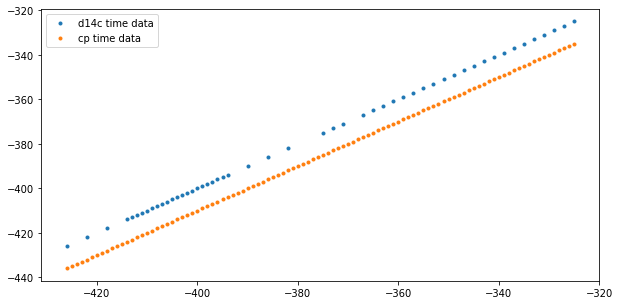

In [5]:
plt.plot(cf.time_data, cf.time_data, ".", label="d14c time data")
plt.plot(cf.control_points_time, cf.control_points_time -10, ".", label="cp time data")
plt.legend()

In [6]:
steady_state = cf.steady_state_production * jnp.ones((len(cf.control_points_time)+1,))
params = steady_state
bounds = tuple([(0, None)] * len(steady_state))

In [7]:
cf.control_points_time

DeviceArray([-426, -425, -424, -423, -422, -421, -420, -419, -418, -417,
             -416, -415, -414, -413, -412, -411, -410, -409, -408, -407,
             -406, -405, -404, -403, -402, -401, -400, -399, -398, -397,
             -396, -395, -394, -393, -392, -391, -390, -389, -388, -387,
             -386, -385, -384, -383, -382, -381, -380, -379, -378, -377,
             -376, -375, -374, -373, -372, -371, -370, -369, -368, -367,
             -366, -365, -364, -363, -362, -361, -360, -359, -358, -357,
             -356, -355, -354, -353, -352, -351, -350, -349, -348, -347,
             -346, -345, -344, -343, -342, -341, -340, -339, -338, -337,
             -336, -335, -334, -333, -332, -331, -330, -329, -328, -327,
             -326, -325], dtype=int64)

In [8]:
params.shape

(103,)

In [9]:
print("total likelihood: ", cf.gp_likelihood(params))
print("gp likelihood: ", cf.gp_neg_log_likelihood(params))
print("chi2: ", cf.loss_chi2(params))

total likelihood:  794.4473052313489
gp likelihood:  79.51007491154928
chi2:  714.9372303197996


In [10]:
%%time
cf.gp_likelihood(params)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 40.3 ms


DeviceArray(794.44730523, dtype=float64)

In [11]:
%%time
soln = scipy.optimize.minimize(cf.gp_likelihood, params, bounds=bounds, tol=2.220446049250313e-09)

CPU times: user 9min 36s, sys: 31.2 ms, total: 9min 36s
Wall time: 9min 36s


In [12]:
soln.x

array([1.64020496, 1.89753848, 2.01179489, 1.9785422 , 1.81363453,
       1.59947136, 1.48841209, 1.48488675, 1.55470805, 1.66057913,
       1.72097105, 1.78765711, 1.98009502, 2.24229633, 2.25534079,
       2.07390008, 2.09996162, 2.1624614 , 2.02154143, 1.89533406,
       2.29156256, 2.36281857, 2.10976963, 1.88188099, 1.92629082,
       1.86123407, 1.87932658, 1.97239226, 2.09059458, 2.42509554,
       2.24717411, 1.98034002, 2.15429256, 2.3680923 , 2.42892708,
       2.38856132, 2.24038707, 2.03315887, 1.93415563, 1.93665946,
       2.00306035, 2.09327783, 2.13070118, 2.12015296, 2.07284067,
       2.00072921, 1.96674321, 1.95691131, 1.95263047, 1.95951212,
       2.01101407, 2.15562078, 2.34533774, 2.41804187, 2.38966125,
       2.36644911, 2.36723508, 2.35487908, 2.30677972, 2.14512009,
       1.95696441, 2.0656364 , 2.36750192, 2.50107729, 2.468006  ,
       2.37943663, 2.23309733, 2.03400008, 1.83934691, 1.80763014,
       1.92377285, 2.11707142, 2.34033932, 2.50999497, 2.58184

In [13]:
cf.gp_likelihood(soln.x)

DeviceArray(87.36106796, dtype=float64)

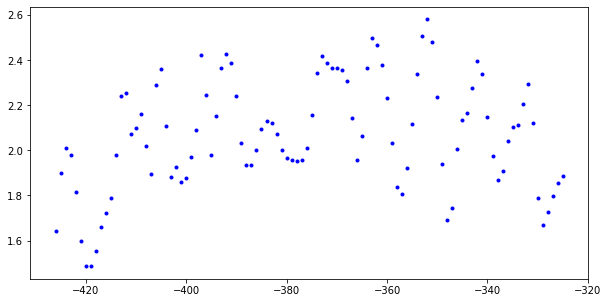

In [14]:
plt.plot(cf.control_points_time, soln.x[:-1], ".b")

In [15]:
soln.message

'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'

In [16]:
cf.gp_likelihood(params=soln.x)

DeviceArray(87.36106796, dtype=float64)

In [17]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  87.36106795812648
gp likelihood:  81.92786143414834
chi2:  5.433206523978149


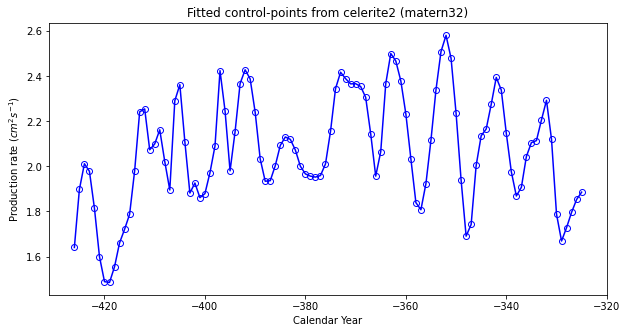

In [18]:
plt.plot(cf.control_points_time, soln.x[:-1], "ob", fillstyle="none")
plt.plot(cf.control_points_time, soln.x[:-1], "b")
plt.ylabel("Production rate ($cm^2s^{-1}$)");
plt.xlabel("Calendar Year");
plt.title(r"Fitted control-points from celerite2 (matern32)");

In [19]:
fine = cf.dc14_fine(params=soln.x)
coarse = cf.dc14(params=soln.x)

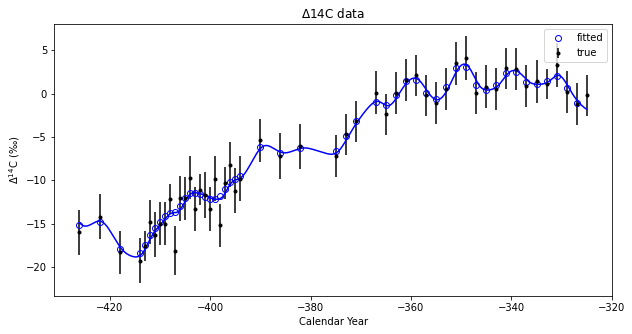

In [20]:
plt.plot(cf.time_grid_fine, fine, "b")
plt.plot(cf.time_data[:-1], coarse, "ob", fillstyle="none", label="fitted")
plt.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt=".k", label="true")
plt.legend()
plt.ylabel("$\Delta^{14}$C (‰)")
plt.xlabel("Calendar Year");
plt.title("$\Delta$14C data");

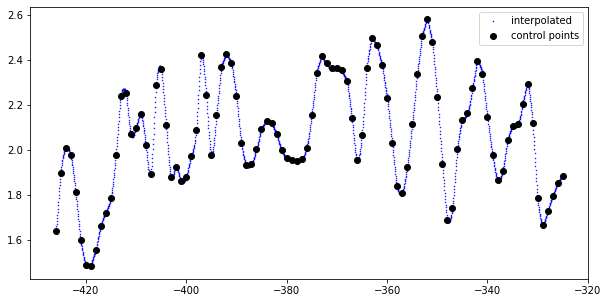

In [22]:
out = cf.production(cf.time_grid_fine, soln.x)
plt.plot(cf.time_grid_fine, out, ".b", markersize=1, label="interpolated")
plt.plot(cf.control_points_time, soln.x[:-1], "ok", label='control points')
plt.legend()